# Autoencoders
Autoencoders are architectures that try to predict the exact same output as the input. There are 2 parts to an autoencoder- an encoder (in which we 'compress' the input) and a decoder (in which we 'expand' the input). 

Given an autoencoder, we can use the encoder to find a representation of the input in much smaller dimensions, while another user can reproduce a close approximation of the original image using the decoder.

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

/Users/pj/miniconda3/envs/np/lib/python3.11/site-packages/datasets/load.py:2097: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [4]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [5]:
bs = 256
tds = dsd.with_transform(transformi) # transform dsd from PNG to tensor

In [6]:
ds = tds['train']
img = ds[0]['image']
type(img)

torch.Tensor

<Axes: >

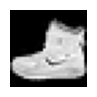

In [7]:
show_image(img, figsize=(1,1))

In [8]:
cf = collate_dict(ds) # allows us to do batching later

In [9]:
def collate_(b): return to_device(cf(b))
# transforms Hugging Face datasets into DataLoader for our training
def data_loaders(dsd, bs, **kwargs):
    return {k:DataLoader(v, bs, **kwargs) for k, v in dsd.items()}

In [10]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [11]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [13]:
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [14]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)
titles

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot')

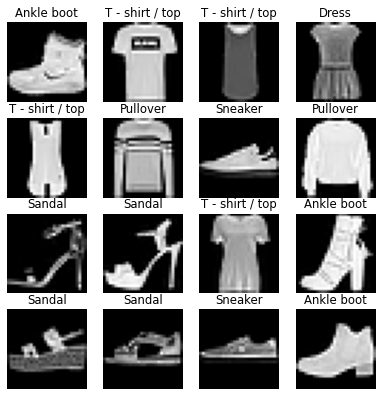

In [15]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Autoencoder
This is how the decoder process of an autoencoder works:
- Use nearest neighbour upsampling (NNS) to transform a smaller input to a larger one. ELI5 on NNS: It's like using a magnifying glass to look at a matrix before making predictions.
- Apply a convolution of stride 1 to the upsampled matrix
Combining the 2 steps above is equivalent to using a convolution to 'upsize' the image.

In [121]:
def deconv(ni, nf, ks=3, act=True):
    res = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(ni, nf, kernel_size=ks, stride=1, padding=ks//2))
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [122]:
autoencoder = nn.Sequential(
    nn.ZeroPad2d(2), # we want the input dim to be a power of 2
    conv(1, 2), # 16 by 16
    conv(2, 4), # 8 by 8
    deconv(4, 2), # 16 by 16
    deconv(2, 1, act=False), # 32 by 32
    nn.ZeroPad2d(-2), # remove initial paddings
    nn.Sigmoid(), # to clamp values between 0 and 1 given our image
).to(def_device)

In [123]:
xb.shape

torch.Size([256, 1, 28, 28])

In [124]:
autoencoder(xb)

tensor([[[[0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          ...,
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54]]],


        [[[0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          ...,
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54]]],


        [[[0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          ...,
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54,  ..., 0.54, 0.54, 0.54],
          [0.54, 0.54, 0.54, 

In [125]:
autoencoder(xb).shape

torch.Size([256, 1, 28, 28])

In [126]:
opt = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

We see that our autoencoder is taking in an input of dimension 28 by 28, and outputting another of dimension 28 by 28. Time to implement the training loop.

In [127]:
def eval(epoch, model, criterion, valid_dl):
    model.eval()
    count = len(valid_dl)
    total_loss = 0.
    for data in valid_dl:
        img, _ = data
        loss = criterion(model(img), img)
        total_loss += loss.item() * len(data)

    print(f"Epoch {epoch}: avg validation loss: {total_loss / count: .4f}")

In [128]:
def fit(num_epochs, model, criterion, opt, train_dl, valid_dl):
    for epoch in range(num_epochs):
        autoencoder.train()
        for data in train_dl:
            img, _ = data
            loss = criterion(autoencoder(img), img)
            loss.backward()
            opt.step()

        eval(epoch, model, criterion, valid_dl)

In [129]:
fit(3, autoencoder, criterion, opt, dt, dv)

Epoch 0: avg validation loss:  0.0969
Epoch 1: avg validation loss:  0.0914
Epoch 2: avg validation loss:  0.0875


We see that our model's validation loss is dropping! Now let's display images generated from our autoencoder and see the results.

In [130]:
xb.shape

torch.Size([256, 1, 28, 28])

In [131]:
dp = xb[:16]
dp.shape

torch.Size([16, 1, 28, 28])

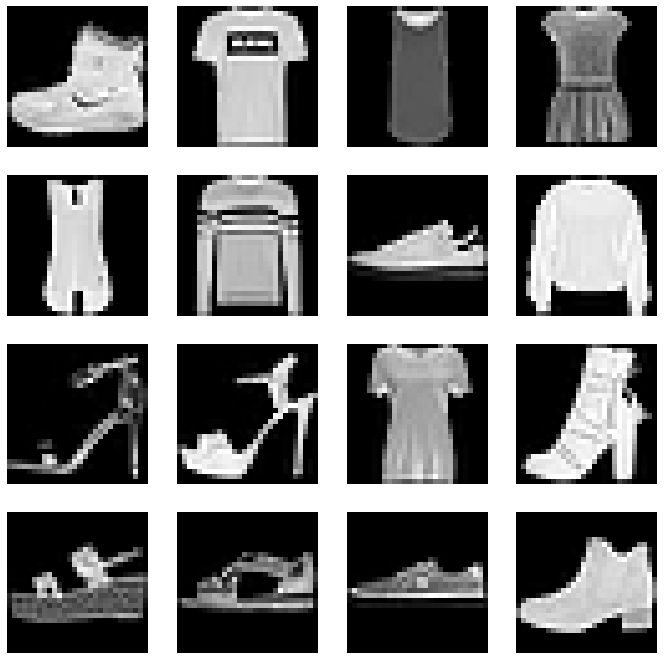

In [132]:
show_images(dp)

The above are our original images. Now let's view the images generated by our autoencoder.

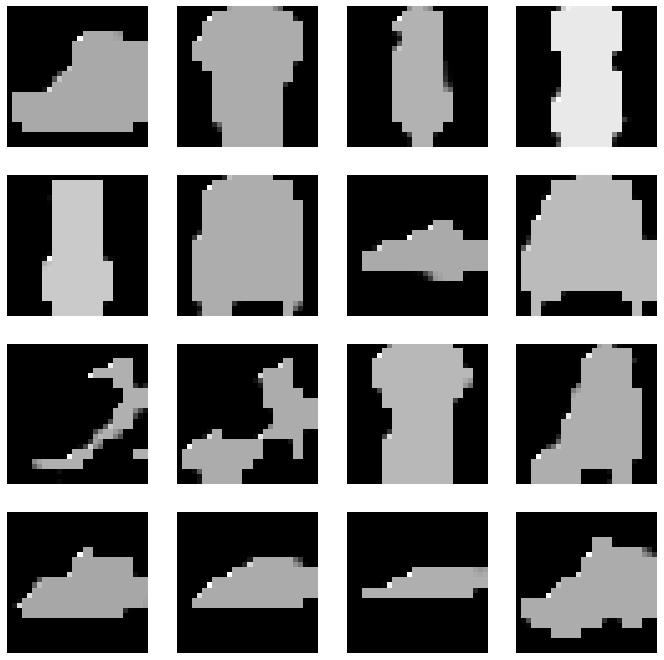

In [133]:
show_images(autoencoder(dp).cpu())

We see that our autoencoder is struggling to learn the details of each image. Right now it only learns the outline of each image.